In [2]:
import sys

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
# from AxialAttention_dynamic import AxialAttention_dynamic as AxialAttention

from torch import Tensor
from torch import nn
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")

PyTorch Version: 1.8.1

Python 3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
GPU is available


In [3]:
class AxialAttention(nn.Module):
    def __init__(self, embed_size, heads, is_width=False):
        super(AxialAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        self.is_width = is_width
        
        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"
        
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)
        
    def forward(self, x):
        if self.is_width:
            y = x.permute(0, 2, 3, 1)
        else:
            y = x.permute(0, 3, 2, 1)
        N, D1, D2, C = y.shape
        y = y.contiguous().view(N * D1, D2, C)
        
        # Split input into self.heads chunks. possible that this needs to go after the linear projections
        y = y.reshape(
                N * D1,
                D2,
                self.heads, 
                self.head_dim
            )
        
        values = self.values(y)
        keys = self.keys(y)
        queries = self.queries(y)
        
        #this is the QK matrix multiply step
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # queries shape: (N, query_len, heads, heads_dim)
        # keys shape: (N, key_len, heads, heads_dim)
        # energy shape: (N, heads, query_len, key_len)
            
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        
        # concat the heads with wierd reshape thing
        y = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, D1, D2, C
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # after einsum: (N, query_len, heads, head_dim) then flatten last two dimensions
        
        y = self.fc_out(y)
        if self.is_width:
            y = y.permute(0, 3, 1, 2)
        else:
            y = y.permute(0, 3, 2, 1)
        return y

In [4]:
class GatedAxialTransformerLayer(nn.Module):
    def __init__(self, in_channels, heads):
        super(GatedAxialTransformerLayer, self).__init__()
        self.in_channels = in_channels
        self.attention_channels = in_channels // 2 # downsample by 50%
        self.heads = heads
        
        # Conv 1x1 to halve size
        self.conv_down = nn.Conv2d(self.in_channels, self.attention_channels, kernel_size=1, stride=1)
        
        # Norm
        self.bn1 = nn.BatchNorm2d(self.attention_channels)
        
        # GatedAxialAttention height
        self.height_attention = AxialAttention(self.attention_channels, heads)
        
        # GatedAxialAttention width
        self.width_attention = AxialAttention(self.attention_channels, heads, is_width=True)
        
        # Conv 1x1 to increase size
        self.conv_up = nn.Conv2d(self.attention_channels, in_channels, kernel_size=1, stride=1)
        
        # Norm
        self.bn2 = nn.BatchNorm2d(self.in_channels)
        
        # ReLU activation
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        # Conv 1x1 to halve size
        y = self.conv_down(x)
        
        # Norm
        y = self.bn1(y)
        
        # ReLU
        y = self.relu(y)
        
        # GatedAxialAttention height
        y = self.height_attention(y)
        
        # GatedAxialAttention width
        y = self.width_attention(y)
        
        # ReLU
        y = self.relu(y)
        
        # Conv 1x1 to increase size
        y = self.conv_up(y)
        
        # Norm
        y = self.bn2(y)
        
        # Residual connection addition from input
        y += x
        
        # ReLU
        y = self.relu(y)
        
        return y

In [27]:
class Encoder(nn.Module):
    def __init__(
        self,
        feature_channels,
        num_transformer_layers,
        color_channels=3,
        conv_kernel_size=7,
        heads=8,
    ):
        super(Encoder, self).__init__()
        
        self.layers = nn.ModuleList(
            [
                # TODO: abstract this, including padding number, see ResNet file
                nn.Conv2d(
                    in_channels=color_channels,
                    out_channels=feature_channels,
                    kernel_size=conv_kernel_size,
                    stride=1,
                    padding=3
                )
            ] +
            [
                GatedAxialTransformerLayer(in_channels=feature_channels, heads=heads) 
                for _ in range(num_transformer_layers)
            ],
        )
        
    def forward(self, x):
        y = x
        
        for layer in self.layers:
            y = layer(y)
        
        return y

In [28]:
class Decoder(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Decoder, self).__init__()
        
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_channels, num_classes)
    
    def forward(self, x):
        y = self.avg(x)
        y = y.view(y.size(0), -1)
        y = self.decoder(y)
        return y

In [73]:
class MedT_C(nn.Module):
    def __init__(
        self,
        img_dim=32,
        in_channels=3,
        patch_dim=8,
        num_classes=10,
        feature_dim=256,
    ):
        super(MedT_C, self).__init__()
        assert img_dim % patch_dim == 0, f"Image dimension {img_dim} is not divisible by patch dimension {patch_dim}."
        self.img_dim = img_dim
        self.patch_dim = patch_dim
        
        self.global_branch = Encoder(feature_dim, 2)
        self.local_branch = Encoder(feature_dim, 5)

        self.decoder = Decoder(feature_dim, num_classes)
        
    def forward(self, x):
        yg = self.global_branch(x)
        # could probably do this with convolution and then reshape, would likely be faster...
        yl = yg.clone()
        for i in range(0,self.img_dim // self.patch_dim):
            for j in range(0,self.img_dim // self.patch_dim):
                patch = x[:,:,self.patch_dim*i:self.patch_dim*(i+1),self.patch_dim*j:self.patch_dim*(j+1)]
                y_patch = self.local_branch(patch)
                yl[:,:,self.patch_dim*i:self.patch_dim*(i+1),self.patch_dim*j:self.patch_dim*(j+1)] = y_patch
        
        y = yg + yl # not sure if this is the right way to do a summation?
        y = self.decoder(y)
        return y

Files already downloaded and verified


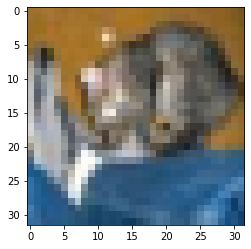

torch.Size([3, 32, 32])

In [74]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(images[0])
images[0].shape

In [75]:
model = MedT_C(
    img_dim=32,
    in_channels=3,
    patch_dim=8,
    num_classes=10,
    feature_dim=256
)

x = images[0].unsqueeze(0)
out = model(x)
out.shape

YLshape: torch.Size([1, 256, 32, 32])


torch.Size([1, 10])

In [76]:
print(model)
summary(model.cuda(), (3, 32, 32))

MedT_C(
  (global_branch): Encoder(
    (layers): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): GatedAxialTransformerLayer(
        (conv_down): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (height_attention): AxialAttention(
          (values): Linear(in_features=16, out_features=16, bias=False)
          (keys): Linear(in_features=16, out_features=16, bias=False)
          (queries): Linear(in_features=16, out_features=16, bias=False)
          (fc_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (width_attention): AxialAttention(
          (values): Linear(in_features=16, out_features=16, bias=False)
          (keys): Linear(in_features=16, out_features=16, bias=False)
          (queries): Linear(in_features=16, out_features=16, bias=False)
          (fc_out): Linear(in_features=128, out_featu

          Linear-300             [-1, 8, 8, 16]             256
          Linear-301             [-1, 8, 8, 16]             256
          Linear-302            [-1, 8, 8, 128]          16,512
  AxialAttention-303            [-1, 128, 8, 8]               0
          Linear-304             [-1, 8, 8, 16]             256
          Linear-305             [-1, 8, 8, 16]             256
          Linear-306             [-1, 8, 8, 16]             256
          Linear-307            [-1, 8, 8, 128]          16,512
  AxialAttention-308            [-1, 128, 8, 8]               0
            ReLU-309            [-1, 128, 8, 8]               0
          Conv2d-310            [-1, 256, 8, 8]          33,024
     BatchNorm2d-311            [-1, 256, 8, 8]             512
            ReLU-312            [-1, 256, 8, 8]               0
GatedAxialTransformerLayer-313            [-1, 256, 8, 8]               0
         Encoder-314            [-1, 256, 8, 8]               0
          Conv2d-315          